# Credit card fraud detection Model


In [276]:
#Libraries
import pandas as pd
from sklearn.ensemble import VotingClassifier
from sklearn.feature_selection import SelectFromModel
from statsmodels.stats.outliers_influence import variance_inflation_factor
#from sklearn.feature_selection import SelectKBest
import plotly.express as px
from sklearn.naive_bayes import GaussianNB
#import imblearn
from imblearn.under_sampling import RandomUnderSampler 
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
#from sklearn.svm import SVC
from xgboost import XGBClassifier
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
#import statsmodels.api as sm
import seaborn as sns
from sklearn.feature_selection import RFE
from statsmodels.stats.stattools import durbin_watson

In [277]:
#df= pd.read_csv('df.csv')
df= pd.read_csv('data.csv')

In [278]:
df_l = df.copy()

## Data processing

In [279]:
#Check the variables that are null
df.isna().sum()

Unnamed: 0                            0
Unnamed: 0.1                          0
cust_id                               0
activated_date                       13
last_payment_date                     9
balance                               2
balance_frequency                     0
purchases                             0
oneoff_purchases                      0
installments_purchases                0
cash_advance                        112
purchases_frequency                   0
oneoff_purchases_frequency            0
purchases_installments_frequency      0
cash_advance_frequency                0
cash_advance_trx                      0
purchases_trx                         0
credit_limit                          1
payments                              0
minimum_payments                    321
prc_full_payment                      0
tenure                                0
fraud                                 0
Year_ad                              13
Month                                13


In [280]:
df_l["balance"] =df_l["balance"].fillna(df_l["balance"].mean())
df_l["minimum_payments"] = df_l["minimum_payments"].fillna(df_l["minimum_payments"].mean())
df_l["minimum_payments"].unique()

array([ 139.509787, 1072.340217,  627.284787, ...,   82.418369,
         55.755628,   88.288956])

In [281]:
#The columns cash_advence, last_payment and activated_date have up to 112 null values in this case I decide to eliminate these rows
df_l = df[df['activated_date'].notna()]
df_l = df[df['last_payment_date'].notna()]
df_l = df[df['cash_advance'].notna()]
df_l.drop(df_l[df_l.activated_date.isnull()].index, inplace = True)


C:\Users\cyn_n\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [282]:
df_l.drop(df_l[df_l.cash_advance.isnull()].index, inplace = True)
df_l.drop(df_l[df_l.last_payment_date.isnull()].index, inplace = True)
df_l.drop(df_l[df_l.credit_limit.isnull()].index, inplace = True)

In [283]:

#Balance had only 2 null values and minimum_payments had the max number of null values and I decided to fill the null
#with the mean.

df_l["balance"] =df_l["balance"].fillna(df_l["balance"].mean())
df_l["minimum_payments"] = df_l["minimum_payments"].fillna(df_l["minimum_payments"].mean())
df_l["minimum_payments"].unique()

<ipython-input-283-c1e41a242a30>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-283-c1e41a242a30>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



array([ 139.509787, 1072.340217,  627.284787, ...,   82.418369,
         55.755628,   88.288956])

In [284]:
df_l.isna().sum()

Unnamed: 0                          0
Unnamed: 0.1                        0
cust_id                             0
activated_date                      0
last_payment_date                   0
balance                             0
balance_frequency                   0
purchases                           0
oneoff_purchases                    0
installments_purchases              0
cash_advance                        0
purchases_frequency                 0
oneoff_purchases_frequency          0
purchases_installments_frequency    0
cash_advance_frequency              0
cash_advance_trx                    0
purchases_trx                       0
credit_limit                        0
payments                            0
minimum_payments                    0
prc_full_payment                    0
tenure                              0
fraud                               0
Year_ad                             0
Month                               0
activated_datec                     0
last_payment

In [13]:
len(df_l)

8816

In [14]:
#Descriptive statistics, we can appreciate that most max values are far away from de mean this indicate that there are a lot 
df_l.describe()


,Unnamed: 0,Unnamed: 0.1,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,...,credit_limit,payments,minimum_payments,prc_full_payment,tenure,fraud,Year_ad,Month,cash/credit_limit,Year_lpd
count,8816.000000,8816.000000,8816.000000,8816.000000,8816.000000,8816.000000,8816.000000,8816.000000,8816.000000,8816.000000,...,8816.000000,8816.000000,8816.000000,8816.000000,8816.000000,8816.000000,8816.000000,8816.000000,8816.000000,8816.0
mean,4469.791062,4470.791062,1566.618008,0.877472,1003.490518,592.738994,411.056269,979.862318,0.490797,0.202320,...,4495.284498,1730.916059,862.312466,0.153815,11.515994,0.007713,2019.705082,6.091084,0.237556,2020.0
std,2583.424101,2583.424101,2084.618780,0.236733,2139.360319,1666.189266,899.873611,2101.400355,0.401580,0.298593,...,3636.513522,2898.515029,2325.380049,0.292515,1.339895,0.087491,0.456032,3.632210,0.415327,0.0
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,150.000000,0.000000,0.019163,0.000000,6.000000,0.000000,2019.000000,1.000000,0.000000,2020.0
25%,2234.750000,2235.750000,128.461138,0.888889,39.745000,0.000000,0.000000,0.000000,0.083333,0.000000,...,1600.000000,383.138344,170.892064,0.000000,12.000000,0.000000,2019.000000,3.000000,0.000000,2020.0
50%,4463.500000,4464.500000,873.942013,1.000000,360.200000,35.985000,89.180000,0.000000,0.500000,0.083333,...,3000.000000,857.298191,335.791097,0.000000,12.000000,0.000000,2020.000000,5.000000,0.000000,2020.0
75%,6706.250000,6707.250000,2055.454055,1.000000,1110.050000,569.902500,469.632500,1115.972139,0.916667,0.285714,...,6500.000000,1899.006999,862.312466,0.142857,12.000000,0.000000,2020.000000,10.000000,0.352516,2020.0
max,8949.000000,8950.000000,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,...,30000.000000,50721.483360,76406.207520,1.000000,12.000000,1.000000,2020.000000,12.000000,10.234862,2020.0


In [15]:
#Change the name for better presentation
df = df.rename(columns = {'Year_ad': 'Activated year'}, inplace = False)
df = df.rename(columns = {'Year_lpd': 'Last payment year'}, inplace = False)


In [65]:
#Observe the outlier of the balance column, there are more outlier in year 2020 a reason could be that we only have 
#data of the last 3 months of 2019 and 7 months from 2020

fig = px.box(df, x="Activated year", y="balance", title="Balance according to activated year")

fig.show()


In [67]:
#In cash/credi_limit there is a outlier that stand out from the others
fig = px.box(df, x="Last payment year", y="cash/credit_limit", title="Cash/credit_limit according to last payment year")
fig.show()

In [18]:

#Obtain a heat map to appreciate which variable have correlation between them and only consider one of each pair in the model

corr_matrix = df.select_dtypes(include=['float64', 'int']).corr(method='pearson')



In [19]:
corr_matrix

,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,credit_limit,payments,minimum_payments,prc_full_payment,Activated year,Month,cash/credit_limit,Last payment year
balance,1.000000,0.322461,0.181280,0.164347,0.126520,0.496922,-0.077875,0.073202,-0.063099,0.449199,0.531294,0.322802,0.398708,-0.319008,-0.165760,0.065254,0.203095,NaN
balance_frequency,0.322461,1.000000,0.133674,0.104323,0.124292,0.098515,0.229715,0.202415,0.176079,0.191873,0.095843,0.065008,0.132568,-0.095082,-0.062112,0.007184,0.062461,NaN
purchases,0.181280,0.133674,1.000000,0.916845,0.679896,-0.051233,0.393017,0.498430,0.315567,-0.120143,0.356963,0.603264,0.093779,0.180379,-0.113677,0.058632,-0.133057,NaN
oneoff_purchases,0.164347,0.104323,0.916845,1.000000,0.330622,-0.031340,0.264937,0.524891,0.127729,-0.082628,0.319724,0.567292,0.048706,0.132763,-0.109259,0.055962,-0.099400,NaN
installments_purchases,0.126520,0.124292,0.679896,0.330622,1.000000,-0.063996,0.442418,0.214042,0.511351,-0.132318,0.256499,0.384084,0.132075,0.182569,-0.067746,0.035648,-0.132644,NaN
cash_advance,0.496922,0.098515,-0.051233,-0.031340,-0.063996,1.000000,-0.216504,-0.087740,-0.177173,0.629030,0.304075,0.452656,0.141676,-0.153302,-0.064898,0.033131,0.688315,NaN
purchases_frequency,-0.077875,0.229715,0.393017,0.264937,0.442418,-0.216504,1.000000,0.501343,0.862934,-0.308478,0.119788,0.103464,0.002954,0.305802,-0.041982,0.044429,-0.319452,NaN
oneoff_purchases_frequency,0.073202,0.202415,0.498430,0.524891,0.214042,-0.087740,0.501343,1.000000,0.142329,-0.111716,0.295038,0.243537,-0.030442,0.157531,-0.120952,0.046755,-0.166549,NaN
purchases_installments_frequency,-0.063099,0.176079,0.315567,0.127729,0.511351,-0.177173,0.862934,0.142329,1.000000,-0.262958,0.060755,0.085551,0.030072,0.250087,-0.012797,0.037999,-0.261173,NaN
cash_advance_frequency,0.449199,0.191873,-0.120143,-0.082628,-0.132318,0.629030,-0.308478,-0.111716,-0.262958,1.000000,0.132616,0.183192,0.098836,-0.249773,-0.010923,-0.002096,0.622863,NaN


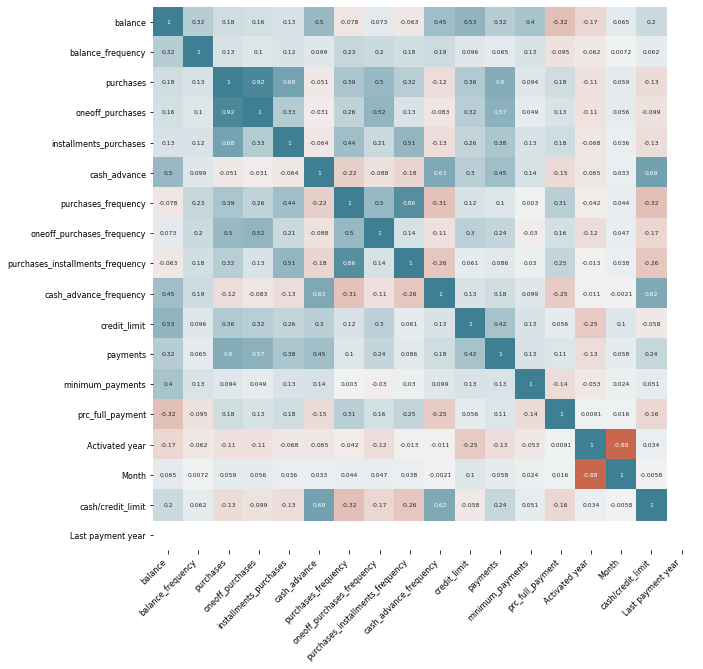

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 6},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 8)

In [21]:
df_l.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'cust_id', 'activated_date',
       'last_payment_date', 'balance', 'balance_frequency', 'purchases',
       'oneoff_purchases', 'installments_purchases', 'cash_advance',
       'purchases_frequency', 'oneoff_purchases_frequency',
       'purchases_installments_frequency', 'cash_advance_frequency',
       'cash_advance_trx', 'purchases_trx', 'credit_limit', 'payments',
       'minimum_payments', 'prc_full_payment', 'tenure', 'fraud', 'Year_ad',
       'Month', 'activated_datec', 'last_payment_datec', 'cash/credit_limit',
       'Year_lpd'],
      dtype='object')

In [69]:
y = df_l["fraud"]
col = [i for i in df_l.columns if i != "fraud" and i!=  "cust_id" and i !="activated_date"and i !="last_payment_date"and i !="last_payment_datec" and i !="activated_datec" and i !="last_payment_datec"and i !="activated_datec"and i !="Unnamed: 0.1" and i !="Unnamed: 0"]
X = df_l[col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [23]:
#Best Predictor

## Best Predictor

In [24]:
#We obtain the best predictor by two ways one is with RFE it is  feature selection algorithm that also uses filter-based
#feature selection internally. It is ordered from the most important to the least.
#With this recursive feature elimination the feature that it's most important is cash_advance_frequency.

model = LogisticRegression(fit_intercept = False)
predictors= X
selector = RFE(model,n_features_to_select =1)
selector= selector.fit(predictors,y)
order =selector.ranking_

C:\Users\cyn_n\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\cyn_n\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\cyn_n\anaconda3\lib\site-packages

In [25]:
feature_ranks =[]
for i in order:
    feature_ranks.append(f"{df_l.columns[i]}")

In [26]:
(feature_ranks)

['cash_advance_frequency',
 'minimum_payments',
 'cash_advance',
 'purchases_frequency',
 'oneoff_purchases_frequency',
 'cash_advance_trx',
 'cust_id',
 'payments',
 'balance',
 'Unnamed: 0.1',
 'installments_purchases',
 'purchases_installments_frequency',
 'purchases_trx',
 'credit_limit',
 'tenure',
 'balance_frequency',
 'purchases',
 'activated_date',
 'oneoff_purchases',
 'prc_full_payment',
 'last_payment_date']

In [27]:
#The second way is SelectFromModel.
smf = SelectFromModel(model, threshold = -np.inf,max_features=len(X.columns))
smf.fit(X_train, y_train)
features_idx =smf.get_support()
features_name =X.columns[features_idx]
list(features_name)

C:\Users\cyn_n\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



['balance',
 'balance_frequency',
 'purchases',
 'oneoff_purchases',
 'installments_purchases',
 'cash_advance',
 'purchases_frequency',
 'oneoff_purchases_frequency',
 'purchases_installments_frequency',
 'cash_advance_frequency',
 'cash_advance_trx',
 'purchases_trx',
 'credit_limit',
 'payments',
 'minimum_payments',
 'prc_full_payment',
 'tenure',
 'Year_ad',
 'Month',
 'cash/credit_limit',
 'Year_lpd']

## Assumptions

In [70]:
#The variables considered were the ones that had most importance and also the ones that were not highly correlated.

X = df_l[['prc_full_payment',"cash_advance",'payments','installments_purchases','balance_frequency','purchases','cash_advance_frequency']]
y = df_l["fraud"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [71]:
#Variance

In [72]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

                  feature       VIF
0        prc_full_payment  1.355637
1            cash_advance  2.897016
2                payments  3.430248
3  installments_purchases  2.270263
4       balance_frequency  2.255513
5               purchases  3.537894
6  cash_advance_frequency  2.617452


In [30]:
#The Vif of the selected variable are low, which show that there is not a lot of  multicollinearity to worry about 

In [31]:
#outliers

In [32]:
#The data has a lot of outliers  if we limit out data to .97 then we only have 80 observation left, in the case of card model, 
#I think it is very important to keep them because they are indicators (For fraud detection outliers analysis methods are recommended).


In [33]:
#filter the quantile

In [34]:
low = .0000000000005
high = .97
quant_df = X.quantile([low, high])
quant_df

,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,...,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure,Year_ad,Month,cash/credit_limit,Year_lpd
5.000000e-13,0.00000,0.0,0.0000,0.0000,0.000,0.00000,0.0,0.0,0.0,0.000000,...,0.0,150.0,0.000000,0.019163,0.0,6.0,2019.0,1.0,0.000000,2020.0
9.700000e-01,7104.95746,1.0,5193.7505,3619.1195,2273.275,6011.41454,1.0,1.0,1.0,0.666667,...,75.0,13500.0,8066.326712,3649.906993,1.0,12.0,2020.0,12.0,1.124689,2020.0


In [35]:
filt_df =X.apply(lambda x: x[(x>quant_df.loc[low,x.name]) & 
                                    (x < quant_df.loc[high,x.name])], axis=0)


## Model

In [228]:
#We divide the data into train set (80%) and test set (20%).
X = df_l[['prc_full_payment',"cash_advance",'payments','installments_purchases','balance_frequency','purchases','cash_advance_frequency']]
y = df_l["fraud"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [195]:
model = LogisticRegression()
model.fit(X_train,y_train)
predict = model.predict(X_test)


## Validation

In [196]:
#Both clases have the same precision but class 0 has more recall than class 1. It is a quite a good model because it has 
#f1-score of .9%
print(classification_report(y_test,predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1748
           1       1.00      0.81      0.90        16

    accuracy                           1.00      1764
   macro avg       1.00      0.91      0.95      1764
weighted avg       1.00      1.00      1.00      1764



In [197]:
def efron_rsquare(y, y_pred):
    n = float(len(y))
    t1 = np.sum(np.power(y - y_pred, 2.0))
    t2 = np.sum(np.power((y - (np.sum(y) / n)), 2.0))
    return 1.0 - (t1 / t2)

In [198]:
#The pseudo r2 is what percentage is correctly determines
#it goes from 0 to 1, it takes the value of 1 if the model fits the data perfectly 0 if the model does not work
efron_rsquare(y_test, predict)

0.8107837528604119

In [199]:
#There are no false positive but there are 3 false negative there are 16 true positives
confusion_matrix(y_test, predict)

array([[1748,    0],
       [   3,   13]], dtype=int64)

In [200]:
#AUC the area under the curve is the ability to distinguish between classes.
y_proba = model.predict_proba(X_test)[::,1]
auc = metrics.roc_auc_score(y_test, y_proba)
print("AUC Logistic Regression :", auc)

AUC Logistic Regression : 0.9583452517162471


In [201]:
#independence of error


In [202]:
erros = y_test-predict
#use de durbin-watson test


# Durbin-Watson test
durbin_watson(erros)

2.0

In [203]:
 
#Because it is in a range of 1.5 - 2.5 we consider the autocorrelation not to be a problem   


## Model 2

In [204]:
#ensemble methods
# That option uses the predicted class labels and takes the majority vote, the model that are considere:
#LogisticRegression, RandomForestClassifier and GaussiaBN

In [205]:
#Hard voting class the predicted class is the class with the highest mayority of votes.
cl_f1 = LogisticRegression(random_state= 5)
cl_f2 = RandomForestClassifier(n_estimators=50, random_state=1)
cl_f3 = GaussianNB()
ensemble = VotingClassifier(estimators=  [   ("lr",cl_f1),("rf",cl_f2),("gnb",cl_f3) ],voting = "hard")

In [206]:
ensemble.fit(X_train,y_train)
y_predict = ensemble.predict(X_test)

In [207]:
efron_rsquare(y_test, predict)

0.8107837528604119

In [208]:
confusion_matrix(y_test, y_predict)

array([[1748,    0],
       [   3,   13]], dtype=int64)

In [98]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1748
           1       1.00      0.81      0.90        16

    accuracy                           1.00      1764
   macro avg       1.00      0.91      0.95      1764
weighted avg       1.00      1.00      1.00      1764



In [55]:
#AUC
y_proba = model.predict_proba(X_test)[::,1]
auc = metrics.roc_auc_score(y_test, y_proba)
print("AUC Logistic Regression :", auc)

AUC Logistic Regression : 0.9583452517162471


# Other Intent Methods

## Undersampling

In [ ]:
#Undersampling, removes observation from the classification mayority class

In [229]:
#define X and Y


Y = df_l["fraud"]
undersample = RandomUnderSampler(sampling_strategy=0.5)

#undersample
X_under, Y_under = undersample.fit_resample(X, Y)

In [230]:

X_train, X_test, y_train, y_test = train_test_split(X_under, Y_under, test_size=0.2, random_state=1)

In [231]:
#train the model
model1 = LogisticRegression(random_state=1)
logit = model1.fit(X_train, y_train)

In [232]:
y_pred_logit = model1.predict(X_test) 

In [233]:
print(classification_report(y_test,y_pred_logit))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92        29
           1       0.89      0.67      0.76        12

    accuracy                           0.88        41
   macro avg       0.88      0.82      0.84        41
weighted avg       0.88      0.88      0.87        41



In [234]:
confusion_matrix(y_test, y_pred_logit)


array([[28,  1],
       [ 4,  8]], dtype=int64)

## Extreme Gradiante boosting

In [215]:

#XGBC Other methods that were used, XGBClassifier eXtreme Gradiante boosting based on desicion tree algorithm it applies better 
#Regularization technique to reduce overfitting.

In [216]:
#train the model
model = XGBClassifier(random_state=4)
xgb = model.fit(X_train, y_train)

[00:31:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\cyn_n\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



In [217]:
#predictions
y_pred_xgb = model.predict(X_test) 

In [218]:
print(classification_report(y_test,y_pred_xgb))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90        29
           1       0.80      0.67      0.73        12

    accuracy                           0.85        41
   macro avg       0.84      0.80      0.81        41
weighted avg       0.85      0.85      0.85        41



In [219]:
confusion_matrix(y_test, y_pred_xgb)

array([[27,  2],
       [ 4,  8]], dtype=int64)

## Oversampling 

In [236]:
#Over sampling
#duplicating examples from the minority class and adding them in the train set, overall, it did not seem to help the model, 
#the classification report has very low in precision and f1-score of the class 1.


In [237]:
X = df_l[['prc_full_payment',"cash_advance",'payments','installments_purchases','balance_frequency','purchases','cash_advance_frequency']]
y = df_l["fraud"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

oversample = SMOTE()

X_r, y_r = oversample.fit_resample(X_train, y_train)

In [238]:
model = LogisticRegression()

In [239]:
model.fit(X_r,y_r)
predict = model.predict(X_test)
print(classification_report(y_test,predict))

              precision    recall  f1-score   support

           0       1.00      0.95      0.98      1748
           1       0.16      0.94      0.27        16

    accuracy                           0.95      1764
   macro avg       0.58      0.95      0.62      1764
weighted avg       0.99      0.95      0.97      1764



In [240]:
#AUC
y_pred_logit_proba = model.predict_proba(X_test)[::,1]
fpr_logit, tpr_logit, _ = metrics.roc_curve(y_test,  y_pred_logit_proba)
auc_logit = metrics.roc_auc_score(y_test, y_pred_logit_proba)
print("AUC Logistic Regression :", auc_logit)

AUC Logistic Regression : 0.9561641876430207


In [241]:
confusion_matrix(y_test, predict)

array([[1669,   79],
       [   1,   15]], dtype=int64)

In [242]:
model.score(X_train,y_train)

0.9522121384004538

## Normalize

In [243]:
#Model is Logistic Regresion, we normilize the data

In [247]:
feature_names = X.columns

In [271]:
X = df_l[['prc_full_payment',"cash_advance",'payments','installments_purchases','balance_frequency','purchases','cash_advance_frequency']]
y = df_l["fraud"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [272]:
X_test

array([[-0.52823913,  1.03799887,  0.05769331, ...,  0.51617097,
        -0.4728093 ,  0.57840483],
       [-0.52823913,  1.86657383, -0.37287722, ...,  0.51617097,
        -0.49957068,  0.57840483],
       [ 1.74562267, -0.46445503, -0.56384153, ..., -1.07417077,
        -0.37214642, -0.67398494],
       ...,
       [-0.52823913, -0.35206809, -0.42364447, ...,  0.51617097,
        -0.49957068,  1.41333301],
       [-0.24400769, -0.46445503,  0.42541326, ...,  0.51617097,
         2.71417496, -0.67398494],
       [-0.52823913, -0.46445503, -0.6170586 , ..., -2.95366632,
        -0.43211763, -0.67398494]])

In [273]:
model.fit(X_train,y_train)
predict = model.predict(X_test)
print(classification_report(y_test,predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1748
           1       1.00      0.81      0.90        16

    accuracy                           1.00      1764
   macro avg       1.00      0.91      0.95      1764
weighted avg       1.00      1.00      1.00      1764



In [274]:
print(metrics.r2_score(y_test,predict))

0.8107837528604119


In [275]:
confusion_matrix(y_test, predict)

array([[1748,    0],
       [   3,   13]], dtype=int64)